## Methods to compare in integration tasks

Harmony and Liger are widely-used data integration / batch effect correction methods that have Python implementations. Harmony is usually considered to be less aggressive in strength, thus keeping more biological variance. Liger is suitable in situations with more severe batch effect.

In [1]:
import scanpy as sc
import sklearn as skl
import pandas as pd
import matplotlib.pyplot as plt
import pickle as pkl

In [2]:
# Some utilities does not work on Windows. Consider using WSL2 on a Windows machine.
# Known probablematic ones: scib.me.clisi_graph
import scib

In [3]:
from tqdm import tqdm

In [30]:
import matplotlib as mpl

## Load data and view the data without integration

In [4]:
adata = sc.read_h5ad('output/demo1-integration.h5ad')

In [5]:
with open("output/demo1-kuanglu-emb.pkl", 'rb') as f:
    adata.obsm['X_kuanglu'] = pkl.load(f)

## Scoring and plotting 

In [6]:
adata.obs.columns

Index(['fov', 'center_x', 'center_y', 'min_x', 'max_x', 'min_y', 'max_y',
       'age', 'clust_annot', 'slice', 'organism_ontology_term_id',
       'sex_ontology_term_id', 'suspension_type', 'cell_type_ontology_term_id',
       'assay_ontology_term_id', 'tissue_ontology_term_id',
       'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id',
       'development_stage_ontology_term_id', 'donor_id', 'is_primary_data',
       'cell_type_annot', 'cell_type', 'assay', 'disease', 'organism', 'sex',
       'tissue', 'self_reported_ethnicity', 'development_stage',
       'donor_slice'],
      dtype='object')

In [7]:
ct = pd.crosstab(adata.obs['cell_type'], adata.obs['donor_slice'])
abundant_cell_types = ct.index[ct.min(axis=1) >= 3].tolist()
print(*abundant_cell_types, sep=', ')

endothelial cell, astrocyte, oligodendrocyte, microglial cell, macrophage, inhibitory interneuron, neuron, pericyte, oligodendrocyte precursor cell, medium spiny neuron, vascular leptomeningeal cell


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/pandas/core/indexes/multi.py:643: DeprecationWarning: `cumproduct` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `cumprod` instead.
  codes = cartesian_product(codes)
/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/pandas/core/reshape/util.py:60: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  return [


In [8]:
adata = adata[adata.obs['cell_type'].isin(abundant_cell_types)]

/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])


In [9]:
label = 'cell_type'
methods = ('liger', 'harmony', 'pca', 'scanorama', 'kuanglu')
batch = "donor_slice"
use_cosine = ['liger', 'scanorama']

In [10]:
scores = {}

for method in tqdm(methods):
    matrix_name = 'X_' + method
    
    if method in use_cosine:
        sc.pp.neighbors(adata, use_rep=matrix_name, metric='cosine')
    else:
        sc.pp.neighbors(adata, use_rep=matrix_name)
        
    s = skl.metrics.silhouette_score(adata.obsm[matrix_name], adata.obs[label])
    
    ilasw = scib.me.isolated_labels_asw(adata, batch_key=batch, label_key=label, embed=matrix_name)
    
    ilf1 = scib.me.isolated_labels_f1(adata, batch_key=batch, label_key="cell_type", embed=None)
    
    db = skl.metrics.davies_bouldin_score(adata.obsm[matrix_name], adata.obs[label])
    ch = skl.metrics.calinski_harabasz_score(adata.obsm[matrix_name], adata.obs[label])
    clisi = scib.me.clisi_graph(adata, label_key=label, type_="knn")
    
    scores[method] = [s, ilasw, ilf1, db, ch, clisi]

  0%|                                                                                             | 0/5 [00:00<?, ?it/s]/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


isolated labels: no more than 3 batches per label
endothelial cell: 0.6412687403358516
astrocyte: 0.7230067652646608
oligodendrocyte: 0.8495613532097013
microglial cell: 0.7952292715957814
macrophage: 0.3597465294869162
inhibitory interneuron: 0.5410958066146098
neuron: 0.5294423446757957
pericyte: 0.5797623591843206
oligodendrocyte precursor cell: 0.7711543478624713
medium spiny neuron: 0.6110647659067594
vascular leptomeningeal cell: 0.5801752162841334
isolated labels: no more than 3 batches per label
endothelial cell: 0.9531843104175454
astrocyte: 0.9620782323081517
oligodendrocyte: 0.9839624169771586
microglial cell: 0.9912629070691024
macrophage: 0.22360248447204967
inhibitory interneuron: 0.9066249347939489
neuron: 0.938880706921944
pericyte: 0.829608938547486
oligodendrocyte precursor cell: 0.9701686121919586
medium spiny neuron: 0.697324414715719
vascular leptomeningeal cell: 0.827338129496403


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-no

isolated labels: no more than 3 batches per label
endothelial cell: 0.6209466829895973
astrocyte: 0.5914808884263039
oligodendrocyte: 0.7077919989824295
microglial cell: 0.7001664042472839
macrophage: 0.5083282478153706
inhibitory interneuron: 0.5187101848423481
neuron: 0.5472064651548862
pericyte: 0.5921606495976448
oligodendrocyte precursor cell: 0.6217486634850502
medium spiny neuron: 0.5872106850147247
vascular leptomeningeal cell: 0.5651208758354187
isolated labels: no more than 3 batches per label
endothelial cell: 0.9819432502149613
astrocyte: 0.9785043899485316
oligodendrocyte: 0.9842381786339756
microglial cell: 0.9968404423380727
macrophage: 0.6415094339622641
inhibitory interneuron: 0.9376278118609408
neuron: 0.9803541110841619
pericyte: 0.8623265741728922
oligodendrocyte precursor cell: 0.9789473684210525
medium spiny neuron: 0.9822357019064125
vascular leptomeningeal cell: 0.8838951310861423


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-no

isolated labels: no more than 3 batches per label
endothelial cell: 0.6060536205768585
astrocyte: 0.5895660817623138
oligodendrocyte: 0.6913270950317383
microglial cell: 0.6883151233196259
macrophage: 0.507359127048403
inhibitory interneuron: 0.5141731640323997
neuron: 0.5368909537792206
pericyte: 0.5861473456025124
oligodendrocyte precursor cell: 0.6148102730512619
medium spiny neuron: 0.5859468206763268
vascular leptomeningeal cell: 0.5620006136596203
isolated labels: no more than 3 batches per label
endothelial cell: 0.9751712328767124
astrocyte: 0.9797521909942581
oligodendrocyte: 0.9865857553497285
microglial cell: 0.9960411718131433
macrophage: 0.6153846153846153
inhibitory interneuron: 0.9230769230769231
neuron: 0.9748888621891145
pericyte: 0.8601921024546424
oligodendrocyte precursor cell: 0.9827357237715804
medium spiny neuron: 0.9770139634801289
vascular leptomeningeal cell: 0.6687306501547987


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-no

isolated labels: no more than 3 batches per label
endothelial cell: 0.625901622603978
astrocyte: 0.6348199257702506
oligodendrocyte: 0.9071187867952839
microglial cell: 0.7102694876014949
macrophage: 0.45761910194783195
inhibitory interneuron: 0.5764718411156223
neuron: 0.7122639076697045
pericyte: 0.630401436600071
oligodendrocyte precursor cell: 0.6247872549567195
medium spiny neuron: 0.587100059225633
vascular leptomeningeal cell: 0.5591229795295289
isolated labels: no more than 3 batches per label
endothelial cell: 0.9578810247503255
astrocyte: 0.964401294498382
oligodendrocyte: 0.9653233364573571
microglial cell: 0.9928853754940711
macrophage: 0.10526315789473685
inhibitory interneuron: 0.8563743948359333
neuron: 0.9517396184062851
pericyte: 0.8042895442359249
oligodendrocyte precursor cell: 0.9490616621983914
medium spiny neuron: 0.6921133875947235
vascular leptomeningeal cell: 0.6515837104072397


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-no

isolated labels: no more than 3 batches per label
endothelial cell: 0.6630861634047137
astrocyte: 0.6302664268292455
oligodendrocyte: 0.7238451451016582
microglial cell: 0.7050428704063558
macrophage: 0.3847030362436734
inhibitory interneuron: 0.6438908043401896
neuron: 0.5928564499007637
pericyte: 0.6386431439984579
oligodendrocyte precursor cell: 0.7554225267324661
medium spiny neuron: 0.6547678866581468
vascular leptomeningeal cell: 0.6543697567860836
isolated labels: no more than 3 batches per label
endothelial cell: 0.9713552800342026
astrocyte: 0.9801324503311258
oligodendrocyte: 0.9862091084028224
microglial cell: 0.9813953488372094
macrophage: 0.049926578560939794
inhibitory interneuron: 0.9478957915831664
neuron: 0.9879076584829607
pericyte: 0.8416666666666667
oligodendrocyte precursor cell: 0.9560723514211886
medium spiny neuron: 0.983401595171373
vascular leptomeningeal cell: 0.6161369193154034


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-no

In [11]:
scores = pd.DataFrame(scores, index=['silhouette', 'ilasw', 'ilf1', 'davies_bouldin', 'calinski_harabasz', 'cLISI']).T


,silhouette,ilasw,ilf1,davies_bouldin,calinski_harabasz,cLISI
liger,0.317215,0.634683,0.844003,1.385586,1644.211564,0.999567
harmony,0.210496,0.596443,0.928038,1.960649,1129.996236,0.999629
pca,0.192487,0.589326,0.903598,2.027106,1018.129636,0.998305
scanorama,0.404610,0.638716,0.808265,1.777999,2981.620375,1.000000
kuanglu,0.305948,0.640627,0.845645,1.625039,2621.571991,1.000000


In [51]:
scores = scores.loc[['kuanglu', 'scanorama', 'harmony', 'liger', 'pca']]

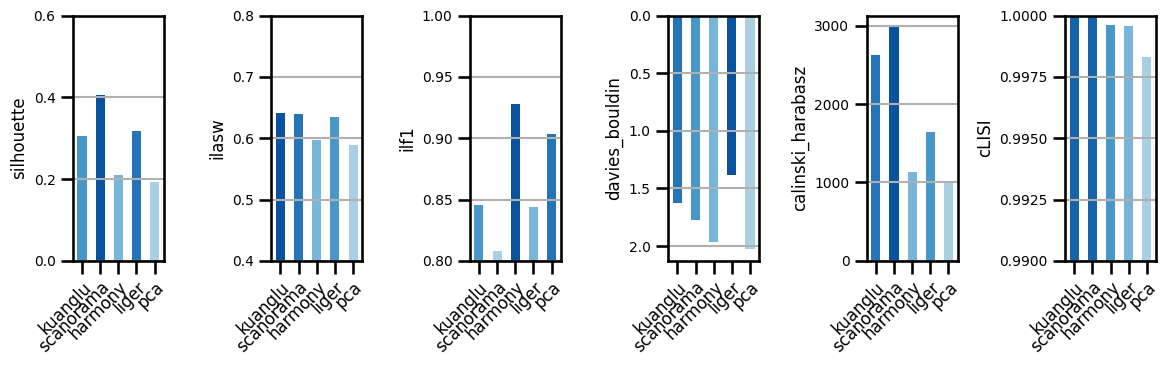

In [74]:
cmap = mpl.colormaps['Blues']
lower_is_better = ['davies_bouldin']
plt.subplots(1, scores.shape[1], figsize=(12, 4))
for i, v in enumerate(scores.columns):
    plt.subplot(1, scores.shape[1], i + 1)
    color = mpl.colormaps['Blues'](1 - scores[v].rank(ascending=v in lower_is_better, pct=True) * .66)
    scores[v].plot(kind='bar', color=color)
    plt.ylabel(v, size=12)
    plt.grid(axis='y')
    plt.yticks(size=10)
    plt.xticks(rotation=45, ha='right', rotation_mode='anchor', size=12)
    
    dmin = scores[v].min()
    dmax = scores[v].max()
    
    if dmin >= 0.0 and dmin <= 1.0 and dmax >= 0.0 and dmax <= 1.0:
        for vmin in [0.99, 0.8, 0.6, 0.4, 0.2, 0.0]:
            if dmin > vmin:
                break
        for vmax in [0.2, 0.4, 0.6, 0.8, 1.0]:
            if dmax < vmax:
                break
        plt.ylim(vmin, vmax)
        
    if v in lower_is_better:
        plt.gca().invert_yaxis()
    
plt.tight_layout()

In [21]:
batch_scores = {}


for method in tqdm(methods):
    matrix_name = 'X_' + method
    
    if method in use_cosine:
        sc.pp.neighbors(adata, use_rep=matrix_name, metric='cosine')
    else:
        sc.pp.neighbors(adata, use_rep=matrix_name)
    
    sb = scib.me.silhouette_batch(adata, batch_key=batch, label_key=label, embed=matrix_name)
        
    gcb = scib.me.graph_connectivity(adata, label_key=label)
    
    ilisi = scib.me.ilisi_graph(adata, batch_key=batch, type_="knn")
    
    # kbet = scib.me.kBET(adata, batch_key=batch, label_key=label, type_="embed", embed=matrix_name)
    
    batch_scores[method] = [sb, gcb, ilisi]

  0%|                                                                                             | 0/5 [00:00<?, ?it/s]

mean silhouette per group:                                 silhouette_score
group                                           
astrocyte                               0.979545
endothelial cell                        0.942630
inhibitory interneuron                  0.962944
macrophage                              0.733093
medium spiny neuron                     0.953258
microglial cell                         0.990419
neuron                                  0.984720
oligodendrocyte                         0.970395
oligodendrocyte precursor cell          0.981221
pericyte                                0.877220
vascular leptomeningeal cell            0.969031


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.o

mean silhouette per group:                                 silhouette_score
group                                           
astrocyte                               0.994978
endothelial cell                        0.930758
inhibitory interneuron                  0.960679
macrophage                              0.937617
medium spiny neuron                     0.973862
microglial cell                         0.957547
neuron                                  0.961358
oligodendrocyte                         0.970393
oligodendrocyte precursor cell          0.981381
pericyte                                0.947688
vascular leptomeningeal cell            0.979542


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.o

mean silhouette per group:                                 silhouette_score
group                                           
astrocyte                               0.960403
endothelial cell                        0.915174
inhibitory interneuron                  0.947904
macrophage                              0.923904
medium spiny neuron                     0.949904
microglial cell                         0.924432
neuron                                  0.938660
oligodendrocyte                         0.909123
oligodendrocyte precursor cell          0.941146
pericyte                                0.933764
vascular leptomeningeal cell            0.954390


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.o

mean silhouette per group:                                 silhouette_score
group                                           
astrocyte                               0.953935
endothelial cell                        0.940679
inhibitory interneuron                  0.957013
macrophage                              0.919320
medium spiny neuron                     0.959641
microglial cell                         0.917921
neuron                                  0.872890
oligodendrocyte                         0.854446
oligodendrocyte precursor cell          0.951149
pericyte                                0.841693
vascular leptomeningeal cell            0.934040


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.o

mean silhouette per group:                                 silhouette_score
group                                           
astrocyte                               0.975345
endothelial cell                        0.962312
inhibitory interneuron                  0.968545
macrophage                              0.933059
medium spiny neuron                     0.962053
microglial cell                         0.974595
neuron                                  0.966634
oligodendrocyte                         0.962968
oligodendrocyte precursor cell          0.923618
pericyte                                0.883333
vascular leptomeningeal cell            0.924667


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.o

In [22]:
batch_scores = pd.DataFrame(batch_scores, index=['silhouette_batch', 'graph_connectivity_batch', 'ilisi']).T

In [24]:
batch_scores = batch_scores.loc[['kuanglu', 'scanorama', 'harmony', 'liger', 'pca']]

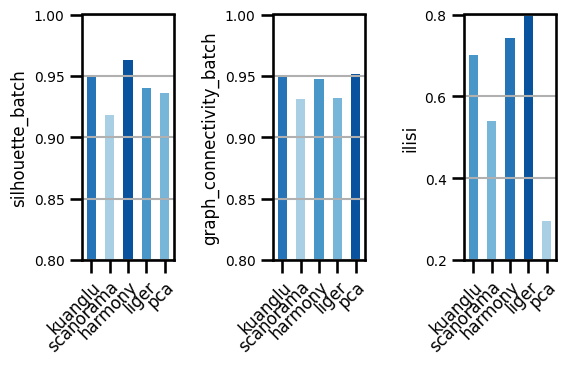

In [73]:
lower_is_better = [] # ['silhouette_batch', 'graph_connectivity_batch', 'ilisi']

plt.subplots(1, batch_scores.shape[1], figsize=(6, 4))
for i, v in enumerate(batch_scores.columns):
    plt.subplot(1, batch_scores.shape[1], i + 1)
    color = mpl.colormaps['Blues'](1 - batch_scores[v].rank(ascending=v in lower_is_better, pct=True) * .66)
    batch_scores[v].plot(kind='bar', color=color)
    plt.ylabel(v, size=12)
    plt.grid(axis='y')
    plt.yticks(size=10)
    plt.xticks(rotation=45, ha='right', rotation_mode='anchor', size=12)
    
    dmin = batch_scores[v].min()
    dmax = batch_scores[v].max()
    
    if dmin >= 0.0 and dmin <= 1.0 and dmax >= 0.0 and dmax <= 1.0:
        for vmin in [0.8, 0.6, 0.4, 0.2, 0.0]:
            if dmin > vmin:
                break
        for vmax in [0.2, 0.4, 0.6, 0.8, 1.0]:
            if dmax < vmax:
                break
        plt.ylim(vmin, vmax)
    
plt.tight_layout()